#### Imports

In [1]:
import numpy as np
import pandas as pd

from ema_workbench import (load_results)

import pickle

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from scipy import spatial

from itertools import combinations

from MesaSchelling import schelling_wrapper
from MesaSchellingReplication import schelling_wrapper as schelling_wrapper_replication

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import ListedColormap
cmap = cm.Dark2

import seaborn as sns

C:\Users\stein042\.conda\envs\robustresilience39\lib\site-packages\ema_workbench\em_framework\evaluators.py:58: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


#### Load data sets

In [2]:
with open('./data/2021-12-17T21-08-maxmin-10000nfe-10repl.pickle','rb') as f:
    loaded_obj = pickle.load(f)

pareto_max,pareto_min, convergence_max,convergence_min = loaded_obj

In [3]:
df_pareto = pd.concat([pareto_min.sort_values(by="n_patches",ascending=True),pareto_max.sort_values(by="n_patches",ascending=False)], ignore_index=True)

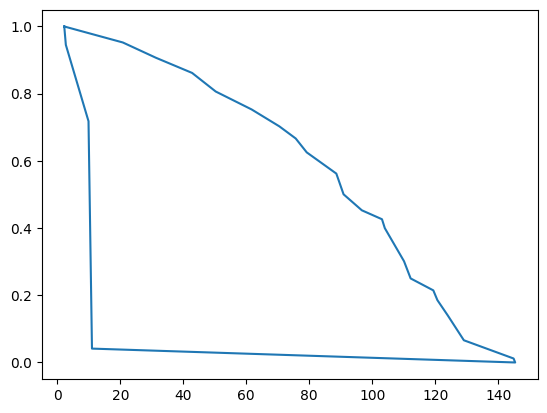

In [4]:
df_pareto_plot = df_pareto._append(df_pareto.iloc[0])

plt.plot(df_pareto_plot["n_patches"],df_pareto_plot["happiness"])
plt.show()

In [5]:
file_name = './data/2021-12-17T14-55-3000runs-10repl.tar.gz'
experiments, outcomes = load_results(file_name)


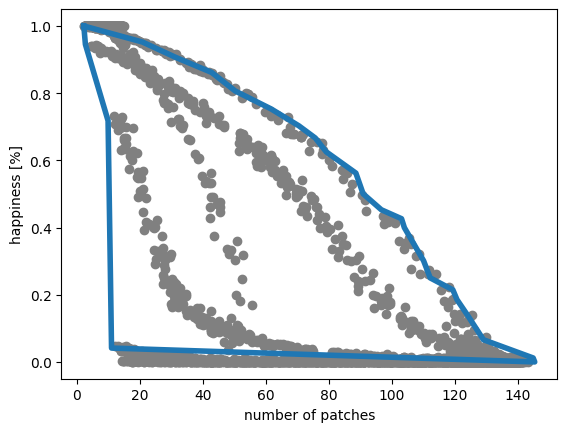

In [6]:
plt.plot(df_pareto_plot["n_patches"], df_pareto_plot["happiness"], linewidth=4)

plt.scatter(x=outcomes["n_patches"], y=outcomes["happiness"], c="grey")

plt.xlabel("number of patches")
plt.ylabel("happiness [%]")
plt.show()

#### Diversity Search

In [7]:
pareto_norm = normalize(df_pareto[['n_patches', 'happiness']],axis=0,norm="max")

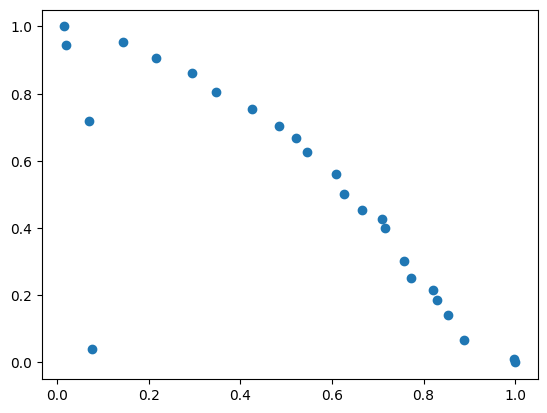

In [8]:
plt.scatter(pareto_norm[:,0],pareto_norm[:,1])
plt.show()

In [9]:
dist_mat = spatial.distance_matrix(pareto_norm, pareto_norm)
dist_mat.shape

(25, 25)

In [10]:
k = 4

In [11]:
indices = df_pareto.index.tolist()

subsets = combinations(indices, k)

distances = {}

for s in subsets:    
    dist_sum = 0
    mini = 1
    maxi = 0
    
    pairs = combinations(s,2)
    for p in pairs:
        this_dist = dist_mat[p[0]][p[1]]
        dist_sum = dist_sum + this_dist
        
        if this_dist > maxi:
            maxi = this_dist
            
        if this_dist < mini:
            mini = this_dist
        
        
    d = {
        "sum": dist_sum,
        "mini": mini,
        "maxi": maxi
    }
        
    #print(d)
    
    distances[s] = [dist_sum, mini, maxi]
    #print("--------------")

In [12]:
df_dist_data = pd.DataFrame.from_dict(distances, orient='index', columns=['sum','min','max'])

In [13]:
max_index = df_dist_data["min"].idxmax()
max_value = df_dist_data["min"].max()

print(max_index, max_value)

(0, 3, 4, 16) 0.6845747251268919


In [14]:
df_most_distant = df_pareto.loc[df_dist_data["min"].idxmax(),:]

df_most_distant

,density,homophily,n_patches,happiness
0,0.898483,4,2.2,0.999758
3,0.949328,7,11.0,0.041286
4,0.353774,7,145.4,0.000000
16,0.340646,4,88.6,0.562036


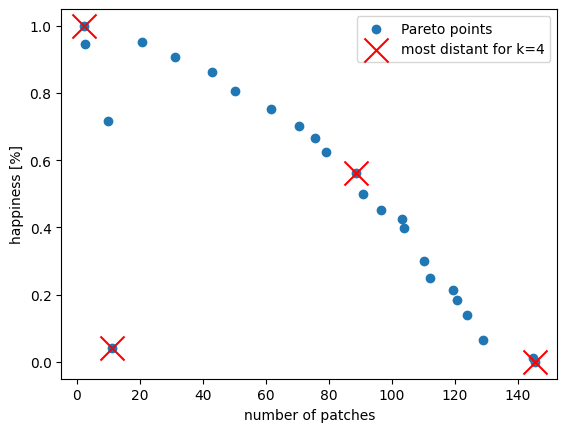

In [15]:
plt.scatter(df_pareto["n_patches"], df_pareto["happiness"], label="Pareto points")
plt.scatter(df_most_distant['n_patches'], df_most_distant['happiness'], marker="x", c="red", s=300, label=f"most distant for k={k}")


plt.xlabel("number of patches")
plt.ylabel("happiness [%]")
plt.legend()
plt.show()

#### Clustering

In [16]:
df_outcomes = pd.DataFrame.from_dict(outcomes,orient='index').transpose()
df_cluster = df_outcomes[["n_patches","happiness"]]

In [17]:
df_cluster.to_numpy()

array([[1.36300000e+02, 3.20158672e-03],
       [1.44000000e+01, 9.46695217e-01],
       [1.14200000e+02, 8.31833742e-03],
       ...,
       [8.21000000e+01, 0.00000000e+00],
       [1.29800000e+02, 7.41936920e-02],
       [1.12900000e+02, 4.25160847e-04]])

In [18]:
normed = normalize(df_cluster,axis=0,norm="max")

kmeans = KMeans(n_clusters = k, random_state=0).fit(normed)

kmeans.labels_

C:\Users\stein042\.conda\envs\robustresilience39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 1, 2, ..., 0, 2, 2])

In [19]:
kmeans.cluster_centers_

array([[0.34915661, 0.02708956],
       [0.08011335, 0.96993772],
       [0.828559  , 0.01630887],
       [0.38102798, 0.56841406]])

In [20]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx]

test = find_nearest(a = df_cluster.to_numpy(), a0 = [0.00236638, 0.03067602])

test

0.030665477461648

In [21]:
np.where(df_cluster.to_numpy() == test)

(array([253], dtype=int64), array([1], dtype=int64))

In [22]:
l = []

for center in kmeans.cluster_centers_:
    test = find_nearest(a = df_cluster.to_numpy(), a0 = center)
    where = np.where(df_cluster.to_numpy() == test)
    l.extend(where[0])
    
l

[2210, 1074, 1323, 779]

In [23]:
df_outcomes.iloc[l]

,n_patches,happiness
2210,73.9,0.027164
1074,14.9,0.969971
1323,28.5,0.016329
779,20.9,0.567385


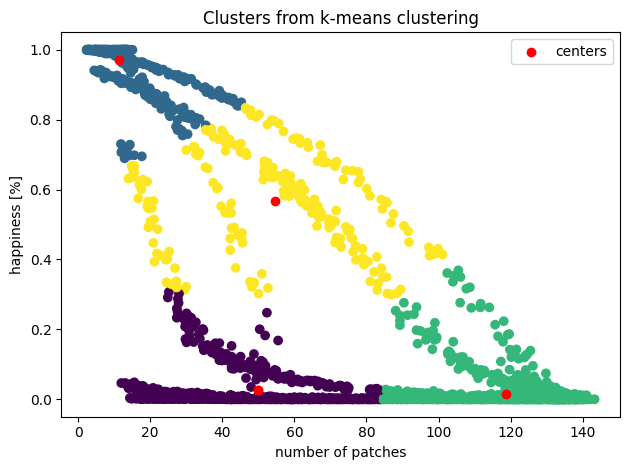

In [179]:
plt.scatter(x=outcomes["n_patches"], y=outcomes["happiness"],c=kmeans.labels_)  

for center in kmeans.cluster_centers_[:1]:
    plt.scatter(x=center[0]*outcomes["n_patches"].max(), y=center[1],c="red", label = 'centers')  

for center in kmeans.cluster_centers_:
    plt.scatter(x=center[0]*outcomes["n_patches"].max(), y=center[1],c="red")  

plt.xlabel("number of patches")
plt.ylabel("happiness [%]")
plt.title('Clusters from k-means clustering')
plt.legend()
plt.tight_layout()
plt.show()

#### Hierarchical clustering

In [133]:
agglom = AgglomerativeClustering(n_clusters=4)

agglom = agglom.fit(normed)

unique, counts = np.unique(agglom.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)


[[   0  815]
 [   1  247]
 [   2 1173]
 [   3  765]]


In [164]:
agglom.children_
rows=np.where(agglom.children_[:,0]<3000)
last = agglom.children_[rows][-4:,0].tolist()
last

agglom_colors = np.repeat(0,3000)
print(agglom_colors)
for v in last:
    agglom_colors[v ] = 1
    
sum(agglom_colors)

[0 0 0 ... 0 0 0]


4

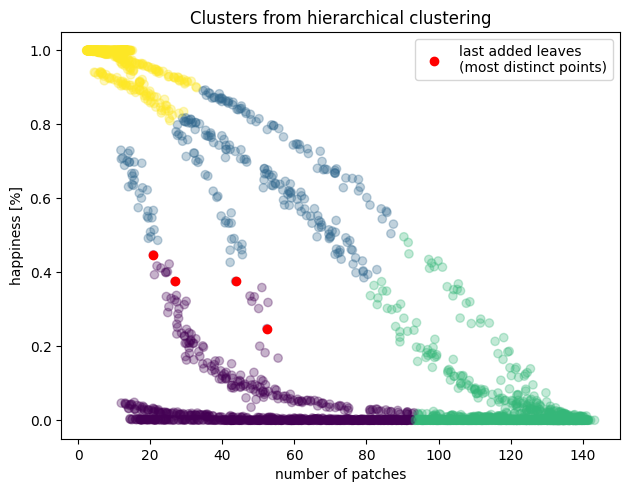

In [174]:
plt.rcdefaults()
plt.scatter(x=outcomes["n_patches"], y=outcomes["happiness"],c = agglom.labels_, alpha = 0.3) 

plt.scatter(x=outcomes["n_patches"][last], y=outcomes["happiness"][last],color = 'r', label = 'last added leaves\n(most distinct points)') 

plt.xlabel("number of patches")
plt.ylabel("happiness [%]")
plt.legend()
plt.tight_layout()
plt.title('Clusters from hierarchical clustering')
plt.show()

#### Put all four scenario generation methods together

In [25]:
def get_closest_outcome_index(df_outcomes, point):
    """point as (x,y) tuple in output space"""
    
    outcomes_norm = normalize(df_outcomes,axis=0,norm="max")
    
    df_outcomes_ext = df_outcomes._append(pd.DataFrame([point], columns=df_outcomes.columns)) #so outcome gets normalized the same
    
    outcomes_ext_norm = normalize(df_outcomes_ext,axis=0,norm="max")
    
    pt = np.array(outcomes_ext_norm[-1],ndmin=2)
    
    ind = spatial.distance.cdist(pt, outcomes_norm).argmin()
    return ind

def get_closest_experiment_index(df_experiments, point):
    """point as (x,y) tuple in input space"""
    
    experiments_norm = normalize(df_experiments,axis=0,norm="max")
    
    df_experiments_ext = df_experiments._append(pd.DataFrame([point], columns=df_experiments.columns))
    
    experiments_ext_norm = normalize(df_experiments_ext,axis=0,norm="max")
    
    pt = np.array(experiments_ext_norm[-1],ndmin=2)
    
    ind = spatial.distance.cdist(pt, experiments_norm).argmin()
    
    return ind

In [26]:
get_closest_experiment_index(experiments[["density","homophily"]], (0.6, 4))

1290

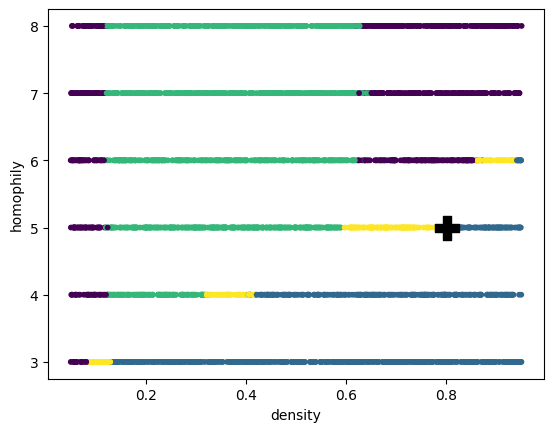

In [27]:
plt.xlabel("density")
plt.ylabel("homophily")

#parameter sweep
plt.scatter(experiments['density'], experiments['homophily'], c=kmeans.labels_, s=10)

plt.scatter(x=experiments['density'][260], y=experiments['homophily'][260],c="black", marker="P", s=300)  

plt.show()

In [28]:
get_closest_outcome_index(df_outcomes[['n_patches','happiness']], (80, 0.25))

1523

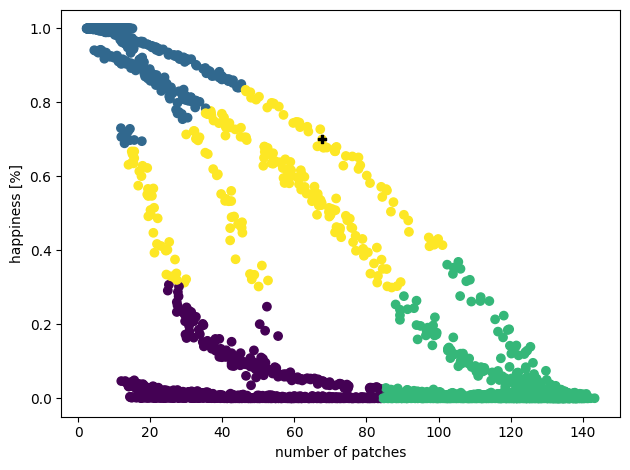

In [29]:
plt.scatter(x=outcomes["n_patches"], y=outcomes["happiness"],c=kmeans.labels_)  
    
plt.scatter(x=outcomes["n_patches"][2789], y=outcomes["happiness"][2789],c="black", marker="P")  


plt.xlabel("number of patches")
plt.ylabel("happiness [%]")
plt.tight_layout()
plt.show()

#### Collect data

In [30]:
sweep_in = experiments[['density','homophily']]
sweep_out = df_outcomes[['n_patches','happiness']]

In [31]:
scenario_matrices_in = np.array([(0.05,3),(0.05,8),(0.95,3),(0.95,8)])
scenario_matrices_out = []
for pt in scenario_matrices_in:
    schelling_data = schelling_wrapper_replication(density = pt[0], homophily = pt[1])
    output_pt = tuple([schelling_data['n_patches'],schelling_data['happiness']])
    scenario_matrices_out.append(output_pt)
    
scenario_matrices_out = np.array(scenario_matrices_out)

print(scenario_matrices_out)

[[4.00000000e+01 0.00000000e+00]
 [4.70000000e+01 0.00000000e+00]
 [5.00000000e+00 1.00000000e+00]
 [1.20000000e+01 4.71142521e-03]]


In [32]:
generic_archetypes_out = np.array([(10,0.2),(10,0.8),(100,0.2),(100,0.8)])
generic_archetypes_in = []
for pt in [(100,0.2)]:
    closest = get_closest_outcome_index(df_outcomes[['n_patches','happiness']], tuple(pt))
    generic_archetypes_in.append(tuple(experiments[["density","homophily"]].iloc[closest]))
generic_archetypes_in = np.array(generic_archetypes_in)

In [33]:
clustering_out = []
for center in kmeans.cluster_centers_: #TODO this is a dirty way of reversing the norming
    this = tuple([center[0]*outcomes["n_patches"].max(), center[1]])
    clustering_out.append(this)
clustering_out = np.array(clustering_out)

clustering_in = []
for pt in clustering_out:
    closest = get_closest_outcome_index(df_outcomes[["n_patches","happiness"]], tuple(pt))
    clustering_in.append(tuple(experiments[["density","homophily"]].iloc[closest]))
clustering_in = np.array(clustering_in)

In [34]:
diversity_search_in = df_most_distant[['density','homophily']]
diversity_search_out = df_most_distant[['n_patches','happiness']]

#### Reorganizing data into single dataframe

In [35]:
df_scenario_matrices = pd.DataFrame({'density':scenario_matrices_in[:,0], 
                                 'homophily':scenario_matrices_in[:,1],
                                'n_patches':scenario_matrices_out[:,0],
                                'happiness':scenario_matrices_out[:,1]})

df_scenario_matrices

,density,homophily,n_patches,happiness
0,0.05,3.0,40.0,0.000000
1,0.05,8.0,47.0,0.000000
2,0.95,3.0,5.0,1.000000
3,0.95,8.0,12.0,0.004711


In [36]:
df_diversity_search = df_most_distant.reset_index(drop=True).copy()
df_diversity_search

,density,homophily,n_patches,happiness
0,0.898483,4,2.2,0.999758
1,0.949328,7,11.0,0.041286
2,0.353774,7,145.4,0.000000
3,0.340646,4,88.6,0.562036


In [37]:
df_generic_archetypes = pd.DataFrame({'density':[pd.NA,pd.NA,generic_archetypes_in[0,0],pd.NA], 
                                 'homophily':[pd.NA,pd.NA,generic_archetypes_in[0,1],pd.NA],
                                'n_patches':generic_archetypes_out[:,0],
                                'happiness':generic_archetypes_out[:,1]})

df_generic_archetypes

,density,homophily,n_patches,happiness
0,<NA>,<NA>,10.0,0.2
1,<NA>,<NA>,10.0,0.8
2,0.574421,5.0,100.0,0.2
3,<NA>,<NA>,100.0,0.8


In [38]:
df_clustering = pd.DataFrame({'density':clustering_in[:,0], 
                                 'homophily':clustering_in[:,1],
                                'n_patches':clustering_out[:,0],
                                'happiness':clustering_out[:,1]})

df_clustering

,density,homophily,n_patches,happiness
0,0.059034,3.0,50.034143,0.027090
1,0.189331,3.0,11.480242,0.969938
2,0.208252,4.0,118.732504,0.016309
3,0.693221,5.0,54.601310,0.568414


In [39]:
df = pd.concat({'diversity search':df_diversity_search, 'scenario matrices':df_scenario_matrices,'generic archetypes':df_generic_archetypes,'clustering':df_clustering}, axis=0, names=["method","scenario"])

df['color_val'] = range(16)
df['marker_style'] = np.repeat(["^","s","X","o"],4)

df

density homophily   n_patches  happiness   
method             scenario                                              
diversity search   0         0.898483         4    2.200000   0.999758  \
                   1         0.949328         7   11.000000   0.041286   
                   2         0.353774         7  145.400000   0.000000   
                   3         0.340646         4   88.600000   0.562036   
scenario matrices  0             0.05       3.0   40.000000   0.000000   
                   1             0.05       8.0   47.000000   0.000000   
                   2             0.95       3.0    5.000000   1.000000   
                   3             0.95       8.0   12.000000   0.004711   
generic archetypes 0             <NA>      <NA>   10.000000   0.200000   
                   1             <NA>      <NA>   10.000000   0.800000   
                   2         0.574421       5.0  100.000000   0.200000   
                   3             <NA>      <NA>  100.000000   0.800000   
clustering         0         0.059034       3.0   50.034143   0.027090   
                   1         0.189331       3.0   11.480242   0.969938   
                   2         0.208252       4.0  118.732504   0.016309   
                   3         0.693221       5.0   54.601310   0.568414   

                             color_val marker_style  
method             scenario                          
diversity search   0                 0            ^  
                   1                 1            ^  
                   2                 2            ^  
                   3                 3            ^  
scenario matrices  0                 4            s  
                   1                 5            s  
                   2                 6            s  
                   3                 7            s  
generic archetypes 0                 8            X  
                   1                 9            X  
                   2                10            X  
                   3                11            X  
clustering         0                12            o  
                   1                13            o  
                   2                14            o  
                   3                15            o

In [40]:
df.dtypes

density          object
homophily        object
n_patches       float64
happiness       float64
color_val         int64
marker_style     object
dtype: object

#### Build plot

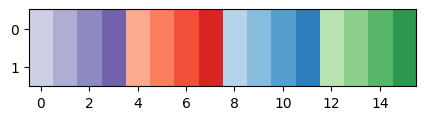

In [41]:
N = 4 # number of colors to extract from each of the base_cmaps below
base_cmaps = ['Purples','Reds','Blues','Greens']

n_base = len(base_cmaps)
colors = np.concatenate([plt.get_cmap(name)(np.linspace(0.3,0.7,N)) for name in base_cmaps])

gradient = np.linspace(0, 1, 16)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(1,1,figsize=(5,1))
ax.imshow(gradient, aspect='auto', cmap=matplotlib.colors.ListedColormap(colors, N=16))

In [42]:
df['density'][0:3]

method            scenario
diversity search  0           0.898483
                  1           0.949328
                  2           0.353774
Name: density, dtype: object

C:\Users\stein042\AppData\Local\Temp\ipykernel_23448\265311469.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(sweep_in['density'], sweep_in['homophily'], color="grey", cmap = cmap, s=10, alpha=0.1)
C:\Users\stein042\AppData\Local\Temp\ipykernel_23448\265311469.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['density'][10], df['homophily'][10], color = colors[10], cmap = cmap, s=300, marker = 'X')
C:\Users\stein042\AppData\Local\Temp\ipykernel_23448\265311469.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['density'][12:16], df['homophily'][12:16], c = colors[12:16], cmap = cmap, s=300, marker = 'o')
C:\Users\stein042\AppData\Local\Temp\ipykernel_23448\265311469.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['density'][0:4], df['

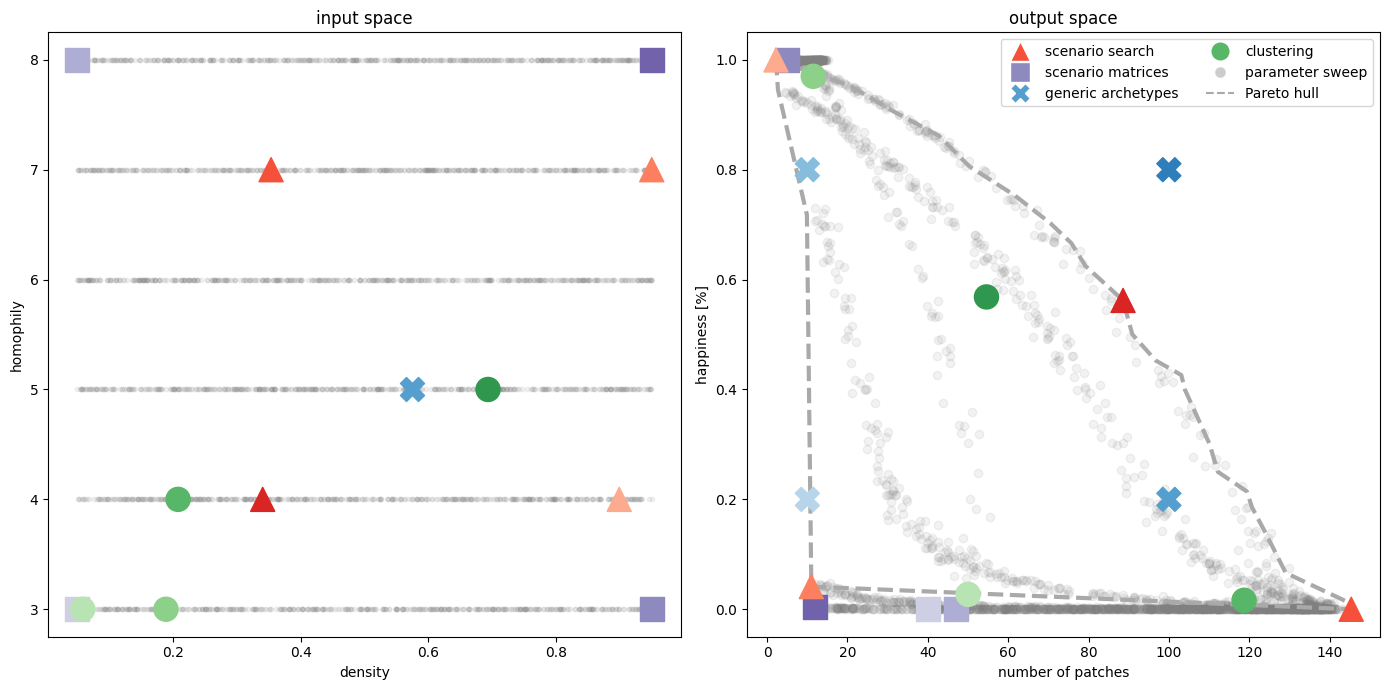

In [43]:
plt.rcParams["figure.figsize"] = (14,7)

plt.subplot(1, 2, 1, title="input space")
plt.xlabel("density")
plt.ylabel("homophily")

plt.scatter(sweep_in['density'], sweep_in['homophily'], color="grey", cmap = cmap, s=10, alpha=0.1)

plt.scatter(df['density'][4:8], df['homophily'][4:8], c = colors[0:4], s=300, marker = 's')
plt.scatter(df['density'][10], df['homophily'][10], color = colors[10], cmap = cmap, s=300, marker = 'X')
plt.scatter(df['density'][12:16], df['homophily'][12:16], c = colors[12:16], cmap = cmap, s=300, marker = 'o')
plt.scatter(df['density'][0:4], df['homophily'][0:4], c = colors[4:8], cmap = cmap, s=300, marker = '^')







plt.subplot(1, 2, 2, title="output space")
plt.xlabel("number of patches")
plt.ylabel("happiness [%]")

plt.scatter(x=sweep_out["n_patches"], y=sweep_out["happiness"], color="grey", alpha=0.1, zorder = 0)

plt.plot(df_pareto_plot["n_patches"],df_pareto_plot["happiness"], color = 'darkgrey', linewidth = 3, zorder=1, linestyle = '--')

plt.scatter(df['n_patches'][4:8], df['happiness'][4:8], c = colors[0:4], s=300, marker = 's')
plt.scatter(df['n_patches'][8:12], df['happiness'][8:12], c = colors[8:12], cmap = cmap, s=300, marker = 'X')
plt.scatter(df['n_patches'][12:16], df['happiness'][12:16], c = colors[12:16], cmap = cmap, s=300, marker = 'o')
plt.scatter(df['n_patches'][0:4], df['happiness'][0:4], c = colors[4:8], cmap = cmap, s=300, marker = '^')



legend_elements = [Line2D([0], [0], color='w', marker="^", markerfacecolor= colors[6], markersize = 14, label=f"scenario search"),
                   Line2D([0], [0], color='w', marker="s", markerfacecolor= colors[2], markersize = 14, label=f"scenario matrices"),
                   Line2D([0], [0], color='w', marker="X", markerfacecolor= colors[10], markersize = 14, label=r"generic archetypes"),
                   Line2D([0], [0], color='w', marker="o", markerfacecolor= colors[14], markersize = 14, label=f"clustering"),
                   Line2D([0], [0], color='w', marker="o", markerfacecolor= 'grey', markersize = 8, alpha = 0.4, label=f"parameter sweep"),
                   Line2D([0], [0], color='darkgrey', marker="o", markerfacecolor= colors[14], markersize = 0, linestyle = '--', label=f"Pareto hull")

                  ]
plt.legend(handles=legend_elements, ncol=2)

#plt.suptitle("Input-output space mapping for different scenario methods", size=30)

plt.tight_layout()
plt.savefig("./figures/input-output", dpi = 600 )
plt.show()

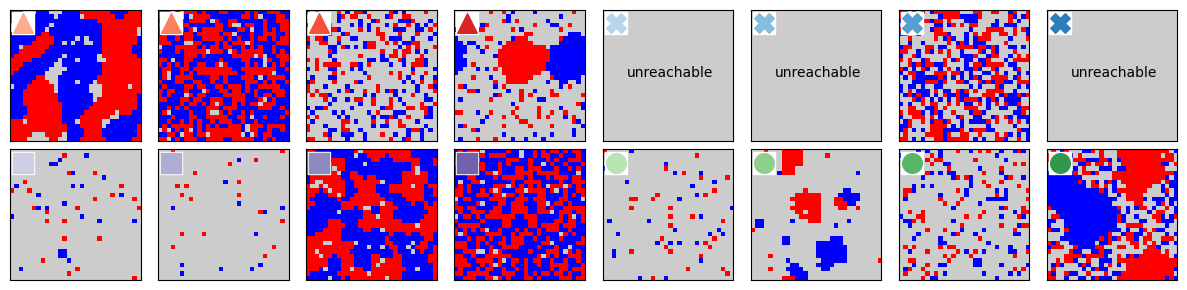

In [44]:
size = (2,8)
cmap_schelling = ListedColormap(['0.8', 'r', 'b']) #[0, 1, 2] for [empty, species 1, species 2]
plt.rcParams["figure.figsize"] = (12,3)

ax1 = plt.subplot2grid(size, (0,0), colspan=1, rowspan = 1)
ax2 = plt.subplot2grid(size, (0,1), colspan=1, rowspan = 1)
ax3 = plt.subplot2grid(size, (0,2), colspan=1, rowspan = 1)
ax4 = plt.subplot2grid(size, (0,3), colspan=1, rowspan = 1)

ax5 = plt.subplot2grid(size, (1,0), colspan=1, rowspan = 1)
ax6 = plt.subplot2grid(size, (1,1), colspan=1, rowspan = 1)
ax7 = plt.subplot2grid(size, (1,2), colspan=1, rowspan = 1)
ax8 = plt.subplot2grid(size, (1,3), colspan=1, rowspan = 1)

ax9 = plt.subplot2grid(size, (0,4), colspan=1, rowspan = 1)
ax10 = plt.subplot2grid(size, (0,5), colspan=1, rowspan = 1)
ax11 = plt.subplot2grid(size, (0,6), colspan=1, rowspan = 1)
ax12 = plt.subplot2grid(size, (0,7), colspan=1, rowspan = 1)

ax13 = plt.subplot2grid(size, (1,4), colspan=1, rowspan = 1)
ax14 = plt.subplot2grid(size, (1,5), colspan=1, rowspan = 1)
ax15 = plt.subplot2grid(size, (1,6), colspan=1, rowspan = 1)
ax16 = plt.subplot2grid(size, (1,7), colspan=1, rowspan = 1)

for i,ax in zip([0,1,2,3],[ax1,ax2,ax3,ax4]):
    
    density = df.loc["diversity search",'density'].iloc[i]
    homophily = df.loc["diversity search",'homophily'].iloc[i]
    ax.matshow(schelling_wrapper(density, homophily)["grid"], cmap=cmap_schelling)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.scatter(2.5,2.5, color = "white" , marker = "s", s = 250)
    pos = i + 4
    ax.scatter(2.5,2.5, color = colors[pos], marker = "^", s = 200)
    
for i,ax in zip([0,1,2,3],[ax5,ax6,ax7,ax8]):
    
    density = df.loc["scenario matrices",'density'].iloc[i]
    homophily = df.loc["scenario matrices",'homophily'].iloc[i]
    ax.matshow(schelling_wrapper(density, homophily)["grid"], cmap=cmap_schelling)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.scatter(2.5,2.5, color = "white" , marker = "s", s = 250)
    pos = i + 0
    ax.scatter(2.5,2.5, color = colors[pos], marker = "s", s = 200)
        
        
for i,ax in zip([0,1,2,3],[ax9,ax10,ax11,ax12]):
  
    try:
        density = df.loc["generic archetypes",'density'].iloc[i]
        homophily = df.loc["generic archetypes",'homophily'].iloc[i]
        ax.matshow(schelling_wrapper(density, homophily)["grid"], cmap=cmap_schelling)
        
    
    except:
        ax.matshow(np.zeros((30,30)), cmap=cmap_schelling)
        ax.annotate("unreachable",(15,15), ha='center')
    
    finally:
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.scatter(2.5,2.5, color = "white" , marker = "s", s = 250)
        pos = i + 8
        ax.scatter(2.5,2.5, color = colors[pos], marker = "X", s = 200)
        
for i,ax in zip([0,1,2,3],[ax13,ax14,ax15,ax16]):
  
    density = df.loc["clustering",'density'].iloc[i]
    homophily = df.loc["clustering",'homophily'].iloc[i]
    ax.matshow(schelling_wrapper(density, homophily)["grid"], cmap=cmap_schelling)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.scatter(2.5,2.5, color = "white" , marker = "s", s = 250)
    pos = i + 12
    ax.scatter(2.5,2.5, color = colors[pos], marker = "o", s = 200)
        
        
plt.tight_layout()
plt.savefig("./figures/maps", dpi = 600 )
plt.show()

## Scenario Comparison Criteria

In [45]:
df

density homophily   n_patches  happiness   
method             scenario                                              
diversity search   0         0.898483         4    2.200000   0.999758  \
                   1         0.949328         7   11.000000   0.041286   
                   2         0.353774         7  145.400000   0.000000   
                   3         0.340646         4   88.600000   0.562036   
scenario matrices  0             0.05       3.0   40.000000   0.000000   
                   1             0.05       8.0   47.000000   0.000000   
                   2             0.95       3.0    5.000000   1.000000   
                   3             0.95       8.0   12.000000   0.004711   
generic archetypes 0             <NA>      <NA>   10.000000   0.200000   
                   1             <NA>      <NA>   10.000000   0.800000   
                   2         0.574421       5.0  100.000000   0.200000   
                   3             <NA>      <NA>  100.000000   0.800000   
clustering         0         0.059034       3.0   50.034143   0.027090   
                   1         0.189331       3.0   11.480242   0.969938   
                   2         0.208252       4.0  118.732504   0.016309   
                   3         0.693221       5.0   54.601310   0.568414   

                             color_val marker_style  
method             scenario                          
diversity search   0                 0            ^  
                   1                 1            ^  
                   2                 2            ^  
                   3                 3            ^  
scenario matrices  0                 4            s  
                   1                 5            s  
                   2                 6            s  
                   3                 7            s  
generic archetypes 0                 8            X  
                   1                 9            X  
                   2                10            X  
                   3                11            X  
clustering         0                12            o  
                   1                13            o  
                   2                14            o  
                   3                15            o

In [46]:
df.index.values

array([('diversity search', 0), ('diversity search', 1),
       ('diversity search', 2), ('diversity search', 3),
       ('scenario matrices', 0), ('scenario matrices', 1),
       ('scenario matrices', 2), ('scenario matrices', 3),
       ('generic archetypes', 0), ('generic archetypes', 1),
       ('generic archetypes', 2), ('generic archetypes', 3),
       ('clustering', 0), ('clustering', 1), ('clustering', 2),
       ('clustering', 3)], dtype=object)

In [47]:
df.index.get_level_values('method').unique().tolist()

['diversity search', 'scenario matrices', 'generic archetypes', 'clustering']

In [48]:
df.loc["diversity search"].iloc[:]

,density,homophily,n_patches,happiness,color_val,marker_style
scenario,,,,,,
0,0.898483,4,2.2,0.999758,0,^
1,0.949328,7,11.0,0.041286,1,^
2,0.353774,7,145.4,0.000000,2,^
3,0.340646,4,88.6,0.562036,3,^


#### Diversity

for each set of scenarios, see how far apart they are.

In [49]:
from scipy.spatial import distance
from itertools import combinations

distances_dict = {}

for method in df.index.get_level_values('method').unique().tolist():
    data = df.loc[method].iloc[:]
    points = []
    for index, row in data.iterrows():
        point = (row['n_patches']/df['n_patches'].max(), row['happiness']) #rescaled to [0,1] for n_patches only
        points.append(point)
    
    distances = []
    for pair in combinations(points,2):
        dist = distance.euclidean(pair[0], pair[1])
        distances.append(dist)
    #print(method,distances)
    distances_dict[method] = distances
#distances_dict

df_distances = pd.DataFrame.from_dict(distances_dict)
df_distances.columns = ['diversity search','scenario matrices','generic archetypes','clustering']
df_distances

,diversity search,scenario matrices,generic archetypes,clustering
0,0.960381,0.048143,0.600000,0.979424
1,1.403383,1.028564,0.618982,0.472601
2,0.738039,0.192630,0.862055,0.542235
3,0.925268,1.040884,0.862055,1.205618
4,0.745665,0.240761,0.618982,0.499173
5,0.684463,0.996452,0.600000,0.706654


In [50]:
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap([colors[6],colors[2],colors[10],colors[14]])

[]

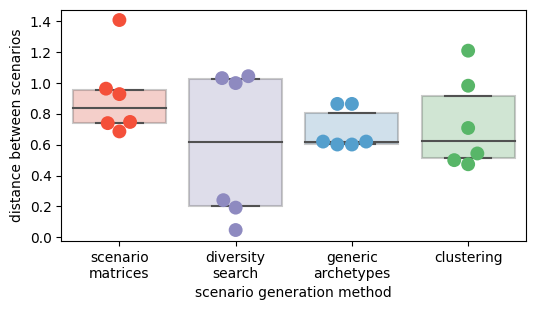

In [51]:
plt.rcParams["figure.figsize"] = (6,3)
s = sns.swarmplot(data=df_distances,size=10, palette = cmap.colors)
s = sns.boxplot(data=df_distances, boxprops=dict(alpha=.3),showfliers=False,whis=0, palette = cmap.colors)
s.set_xticklabels(['scenario\nmatrices','diversity\nsearch','generic\narchetypes','clustering'])
plt.xlabel('scenario generation method')
plt.ylabel('distance between scenarios')
s.plot()

#### Plausibility

for each scenario, see how far it is from a model output from the parameter sweep.

In [52]:
df

density homophily   n_patches  happiness   
method             scenario                                              
diversity search   0         0.898483         4    2.200000   0.999758  \
                   1         0.949328         7   11.000000   0.041286   
                   2         0.353774         7  145.400000   0.000000   
                   3         0.340646         4   88.600000   0.562036   
scenario matrices  0             0.05       3.0   40.000000   0.000000   
                   1             0.05       8.0   47.000000   0.000000   
                   2             0.95       3.0    5.000000   1.000000   
                   3             0.95       8.0   12.000000   0.004711   
generic archetypes 0             <NA>      <NA>   10.000000   0.200000   
                   1             <NA>      <NA>   10.000000   0.800000   
                   2         0.574421       5.0  100.000000   0.200000   
                   3             <NA>      <NA>  100.000000   0.800000   
clustering         0         0.059034       3.0   50.034143   0.027090   
                   1         0.189331       3.0   11.480242   0.969938   
                   2         0.208252       4.0  118.732504   0.016309   
                   3         0.693221       5.0   54.601310   0.568414   

                             color_val marker_style  
method             scenario                          
diversity search   0                 0            ^  
                   1                 1            ^  
                   2                 2            ^  
                   3                 3            ^  
scenario matrices  0                 4            s  
                   1                 5            s  
                   2                 6            s  
                   3                 7            s  
generic archetypes 0                 8            X  
                   1                 9            X  
                   2                10            X  
                   3                11            X  
clustering         0                12            o  
                   1                13            o  
                   2                14            o  
                   3                15            o

In [53]:
points_dict = {}

for method in df.index.get_level_values('method').unique().tolist():
    data = df.loc[method].iloc[:]
    points = []
    for index, row in data.iterrows():
        point = (row['n_patches'], row['happiness'])
        points.append(point)
    points_dict[method] = points

In [54]:
points_dict

{'diversity search': [(2.2, 0.9997578692493947),
  (11.0, 0.041285915956739486),
  (145.4, 0.0),
  (88.6, 0.5620363384916099)],
 'scenario matrices': [(40.0, 0.0),
  (47.0, 0.0),
  (5.0, 1.0),
  (12.0, 0.004711425206124852)],
 'generic archetypes': [(10.0, 0.2), (10.0, 0.8), (100.0, 0.2), (100.0, 0.8)],
 'clustering': [(50.03414285714285, 0.02708956301503057),
  (11.480242424242425, 0.9699377208320499),
  (118.7325040128411, 0.016308873840841953),
  (54.60131004366813, 0.5684140568534617)]}

In [55]:
points_dict['generic archetypes'][2]

(100.0, 0.2)

In [56]:
loc = get_closest_outcome_index(df_outcomes[['n_patches','happiness']], points_dict['generic archetypes'][2])
loc

1903

In [57]:
threshold = 0.05

In [58]:
plausibility_dict = {}

for key in points_dict.keys():
    print("----------",key)
    distances = []
    for point in points_dict[key]:
        print(point)
        closest_index = get_closest_outcome_index(df_outcomes[['n_patches','happiness']], point)
        closest = df_outcomes.loc[closest_index]
        print("closest:\n",(closest['n_patches'],closest['happiness']))
        point_rescaled = (point[0]/df['n_patches'].max(),point[1])
        closest_rescaled = (closest['n_patches']/df['n_patches'].max(),closest['happiness'])
        dist = distance.euclidean(point_rescaled,closest_rescaled)
        distances.append(dist)
        print("dist",dist)
        if dist > threshold:
             print("WARNING, exceeded threshold")
    plausibility_dict[key] = distances

---------- diversity search
(2.2, 0.9997578692493947)
closest:
 (2.4, 1.0)
dist 0.0013966642642901322
(11.0, 0.041285915956739486)
closest:
 (12.0, 0.0464217488758527)
dist 0.008583581649984882
(145.4, 0.0)
closest:
 (143.3, 0.0)
dist 0.014442916093534985
(88.6, 0.5620363384916099)
closest:
 (85.7, 0.5619279555338391)
dist 0.019945273846855682
---------- scenario matrices
(40.0, 0.0)
closest:
 (39.9, 0.0009870708492929)
dist 0.0012030460519917275
(47.0, 0.0)
closest:
 (47.2, 0.0)
dist 0.0013755158184319827
(5.0, 1.0)
closest:
 (5.0, 1.0)
dist 0.0
(12.0, 0.004711425206124852)
closest:
 (14.4, 0.0039031688168375)
dist 0.016525966864415143
---------- generic archetypes
(10.0, 0.2)
closest:
 (27.4, 0.2333051446865374)
dist 0.12421800164698542
WARNING, exceeded threshold
(10.0, 0.8)
closest:
 (11.9, 0.7304277053361431)
dist 0.07078884894349043
WARNING, exceeded threshold
(100.0, 0.2)
closest:
 (98.5, 0.1967332421348728)
dist 0.010821236936201748
(100.0, 0.8)
closest:
 (77.8, 0.6513087499272

In [59]:
plausibility_dict

df_plausibility = pd.DataFrame.from_dict(plausibility_dict)

In [60]:
df_plausibility

,diversity search,scenario matrices,generic archetypes,clustering
0,0.001397,0.001203,0.124218,0.016100
1,0.008584,0.001376,0.070789,0.001544
2,0.014443,0.000000,0.010821,0.003206
3,0.019945,0.016526,0.213122,0.023097


In [61]:
df_plausibility_recip = 1 / ((df_plausibility + 1))

df_plausibility_recip

,diversity search,scenario matrices,generic archetypes,clustering
0,0.998605,0.998798,0.889507,0.984155
1,0.991489,0.998626,0.933891,0.998458
2,0.985763,1.000000,0.989295,0.996805
3,0.980445,0.983743,0.824319,0.977425


[]

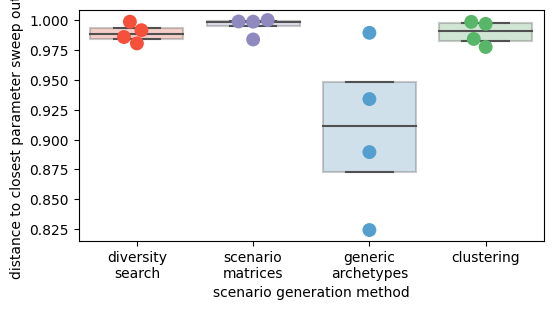

In [62]:
plt.rcParams["figure.figsize"] = (6,3)
s = sns.swarmplot(data=df_plausibility_recip,size=10, palette = cmap.colors)#, marker="s")
s = sns.boxplot(data=df_plausibility_recip, boxprops=dict(alpha=.3),showfliers=False,whis=0, palette = cmap.colors)
s.set_xticklabels(['diversity\nsearch','scenario\nmatrices','generic\narchetypes','clustering'])
plt.xlabel('scenario generation method')
plt.ylabel('distance to closest parameter sweep output')
s.plot()

#### Coverage

compare covered polygon surface formed by scenario points with polygon surface covered by pareto front

In [63]:
def area_by_shoelace(x, y):
    "Assumes x,y points go around the polygon in one direction"
    return abs( sum(i * j for i, j in zip(x,             y[1:] + y[:1]))
               -sum(i * j for i, j in zip(x[1:] + x[:1], y            ))) / 2
 
points = [(3,4), (5,11), (12,8), (9,5), (5,6)]
x, y = zip(*points)
area_by_shoelace(x, y)

30.0

In [64]:
pareto_area = area_by_shoelace(df_pareto_plot['n_patches'].tolist(), df_pareto_plot['happiness'].tolist())

pareto_area

74.86040103602693

In [65]:
for method in df.index.get_level_values('method').unique().tolist():
    data = df.loc[method].iloc[:]
    
    area = area_by_shoelace(data['n_patches'].tolist(), data['happiness'].tolist())
    
    print(method, area)
    
    print("---")

diversity search 76.07633558037324
---
scenario matrices 17.417550058892814
---
generic archetypes 0.0
---
clustering 13.559571426848052
---


In [66]:
data = df.loc['generic archetypes'].iloc[:]
data

,density,homophily,n_patches,happiness,color_val,marker_style
scenario,,,,,,
0,<NA>,<NA>,10.0,0.2,8,X
1,<NA>,<NA>,10.0,0.8,9,X
2,0.574421,5.0,100.0,0.2,10,X
3,<NA>,<NA>,100.0,0.8,11,X


In [67]:
x = data['n_patches'].tolist()
y = data['happiness'].tolist()

print(x)
print(y)

area = area_by_shoelace(x, y)
area

[10.0, 10.0, 100.0, 100.0]
[0.2, 0.8, 0.2, 0.8]


0.0

In [68]:
df.index.get_level_values('method').unique().tolist()

['diversity search', 'scenario matrices', 'generic archetypes', 'clustering']

In [69]:
df.loc['scenario matrices'].iloc[:]

,density,homophily,n_patches,happiness,color_val,marker_style
scenario,,,,,,
0,0.05,3.0,40.0,0.000000,4,s
1,0.05,8.0,47.0,0.000000,5,s
2,0.95,3.0,5.0,1.000000,6,s
3,0.95,8.0,12.0,0.004711,7,s


In [70]:
df

density homophily   n_patches  happiness   
method             scenario                                              
diversity search   0         0.898483         4    2.200000   0.999758  \
                   1         0.949328         7   11.000000   0.041286   
                   2         0.353774         7  145.400000   0.000000   
                   3         0.340646         4   88.600000   0.562036   
scenario matrices  0             0.05       3.0   40.000000   0.000000   
                   1             0.05       8.0   47.000000   0.000000   
                   2             0.95       3.0    5.000000   1.000000   
                   3             0.95       8.0   12.000000   0.004711   
generic archetypes 0             <NA>      <NA>   10.000000   0.200000   
                   1             <NA>      <NA>   10.000000   0.800000   
                   2         0.574421       5.0  100.000000   0.200000   
                   3             <NA>      <NA>  100.000000   0.800000   
clustering         0         0.059034       3.0   50.034143   0.027090   
                   1         0.189331       3.0   11.480242   0.969938   
                   2         0.208252       4.0  118.732504   0.016309   
                   3         0.693221       5.0   54.601310   0.568414   

                             color_val marker_style  
method             scenario                          
diversity search   0                 0            ^  
                   1                 1            ^  
                   2                 2            ^  
                   3                 3            ^  
scenario matrices  0                 4            s  
                   1                 5            s  
                   2                 6            s  
                   3                 7            s  
generic archetypes 0                 8            X  
                   1                 9            X  
                   2                10            X  
                   3                11            X  
clustering         0                12            o  
                   1                13            o  
                   2                14            o  
                   3                15            o

In [71]:
df_outputs = df[['n_patches','happiness']]
df_outputs

n_patches  happiness
method             scenario                       
diversity search   0           2.200000   0.999758
                   1          11.000000   0.041286
                   2         145.400000   0.000000
                   3          88.600000   0.562036
scenario matrices  0          40.000000   0.000000
                   1          47.000000   0.000000
                   2           5.000000   1.000000
                   3          12.000000   0.004711
generic archetypes 0          10.000000   0.200000
                   1          10.000000   0.800000
                   2         100.000000   0.200000
                   3         100.000000   0.800000
clustering         0          50.034143   0.027090
                   1          11.480242   0.969938
                   2         118.732504   0.016309
                   3          54.601310   0.568414

In [72]:
df_outputs.loc['diversity search',0]

n_patches    2.200000
happiness    0.999758
Name: (diversity search, 0), dtype: float64

In [73]:
ordered_points_dict =  {
    'ds': [tuple(df_outputs.loc['diversity search',0]),tuple(df_outputs.loc['diversity search',1]),tuple(df_outputs.loc['diversity search',2]),tuple(df_outputs.loc['diversity search',3])],
    'sm': [tuple(df_outputs.loc['scenario matrices',2]),tuple(df_outputs.loc['scenario matrices',0]),tuple(df_outputs.loc['scenario matrices',1]),tuple(df_outputs.loc['scenario matrices',3])],
    'ga': [(10.000000,0.800000),(100.000000,0.800000),(100.000000,0.200000),(10.000000,0.200000)],
    'cl': [tuple(df_outputs.loc['clustering',1]),tuple(df_outputs.loc['clustering',3]),tuple(df_outputs.loc['clustering',2]),tuple(df_outputs.loc['clustering',0])]
}

ordered_points_dict

{'ds': [(2.2, 0.9997578692493947),
  (11.0, 0.041285915956739486),
  (145.4, 0.0),
  (88.6, 0.5620363384916099)],
 'sm': [(5.0, 1.0), (40.0, 0.0), (47.0, 0.0), (12.0, 0.004711425206124852)],
 'ga': [(10.0, 0.8), (100.0, 0.8), (100.0, 0.2), (10.0, 0.2)],
 'cl': [(11.480242424242425, 0.9699377208320499),
  (54.60131004366813, 0.5684140568534617),
  (118.7325040128411, 0.016308873840841953),
  (50.03414285714285, 0.02708956301503057)]}

In [74]:
comprehensiveness_dict = {}

for key in ordered_points_dict:
    #print(ordered_points_dict[key])
    x, y = zip(*ordered_points_dict[key])
    area = area_by_shoelace(x, y)
    print(f"{key}: {area}, {round(area*100/pareto_area,1)}%")
    comprehensiveness_dict[key] = round(area*100/pareto_area,1)

ds: 76.07633558037324, 101.6%
sm: 13.901060070671377, 18.6%
ga: 54.0, 72.1%
cl: 31.206829297788687, 41.7%


In [75]:
list(comprehensiveness_dict.values())

[101.6, 18.6, 72.1, 41.7]

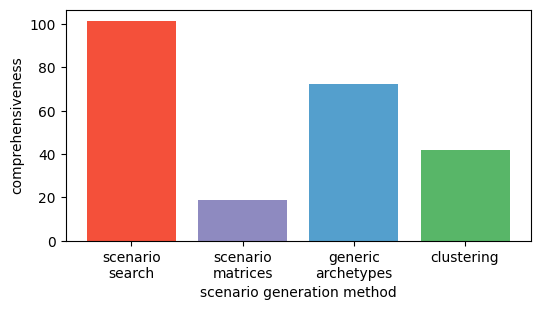

In [76]:
plt.bar(x=[1,2,3,4], height = list(comprehensiveness_dict.values()), color = cmap.colors, tick_label = ['scenario\nsearch','scenario\nmatrices','generic\narchetypes','clustering'])
plt.xlabel('scenario generation method')
plt.ylabel('comprehensiveness')
plt.show()

#### Comparison

In [77]:
df_distances.mean()

diversity search      0.909533
scenario matrices     0.591239
generic archetypes    0.693679
clustering            0.734284
dtype: float64

In [78]:
pcoord_data = {
    'diversity': df_distances.mean().tolist(),
    'plausibility': df_plausibility_recip.mean().tolist(),
    'comprehensiveness': list(comprehensiveness_dict.values()),
    'method': ['diversity search','scenario matrices', 'generic archetypes', 'clustering']
}

pcoord_data

{'diversity': [0.9095331338927952,
  0.5912390523131504,
  0.6936790471152582,
  0.7342843783416262],
 'plausibility': [0.9890755563729294,
  0.9952918684699495,
  0.9092530457926248,
  0.9892107494763895],
 'comprehensiveness': [101.6, 18.6, 72.1, 41.7],
 'method': ['diversity search',
  'scenario matrices',
  'generic archetypes',
  'clustering']}

In [79]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()

radar_df = pd.DataFrame(data = pcoord_data, index = None, columns = ['diversity', 'plausibility', 'comprehensiveness','method'])

print(radar_df)

radar_df['comprehensiveness'] = radar_df['comprehensiveness'] / 100

b = 1
a = 0.5

radar_df['plausibility'] = (b - a) * (radar_df['plausibility'] - min(radar_df['plausibility']))/(max(radar_df['plausibility']) - min(radar_df['plausibility'])) + a

#radar_df['plausibility'] = scaler.fit_transform(radar_df['plausibility'])

print(radar_df)

#radar_df['plausibility'] = 1 - radar_df['plausibility']



#radar_df['plausibility'] = (radar_df['plausibility'] - min(radar_df['plausibility'])) / (max(radar_df['plausibility']) - min(radar_df['plausibility']))


print(radar_df)

   diversity  plausibility  comprehensiveness              method
0   0.909533      0.989076              101.6    diversity search
1   0.591239      0.995292               18.6   scenario matrices
2   0.693679      0.909253               72.1  generic archetypes
3   0.734284      0.989211               41.7          clustering
   diversity  plausibility  comprehensiveness              method
0   0.909533      0.963875              1.016    diversity search
1   0.591239      1.000000              0.186   scenario matrices
2   0.693679      0.500000              0.721  generic archetypes
3   0.734284      0.964661              0.417          clustering
   diversity  plausibility  comprehensiveness              method
0   0.909533      0.963875              1.016    diversity search
1   0.591239      1.000000              0.186   scenario matrices
2   0.693679      0.500000              0.721  generic archetypes
3   0.734284      0.964661              0.417          clustering


In [80]:
def append_first(l):
    l.append(l[0])
    return l

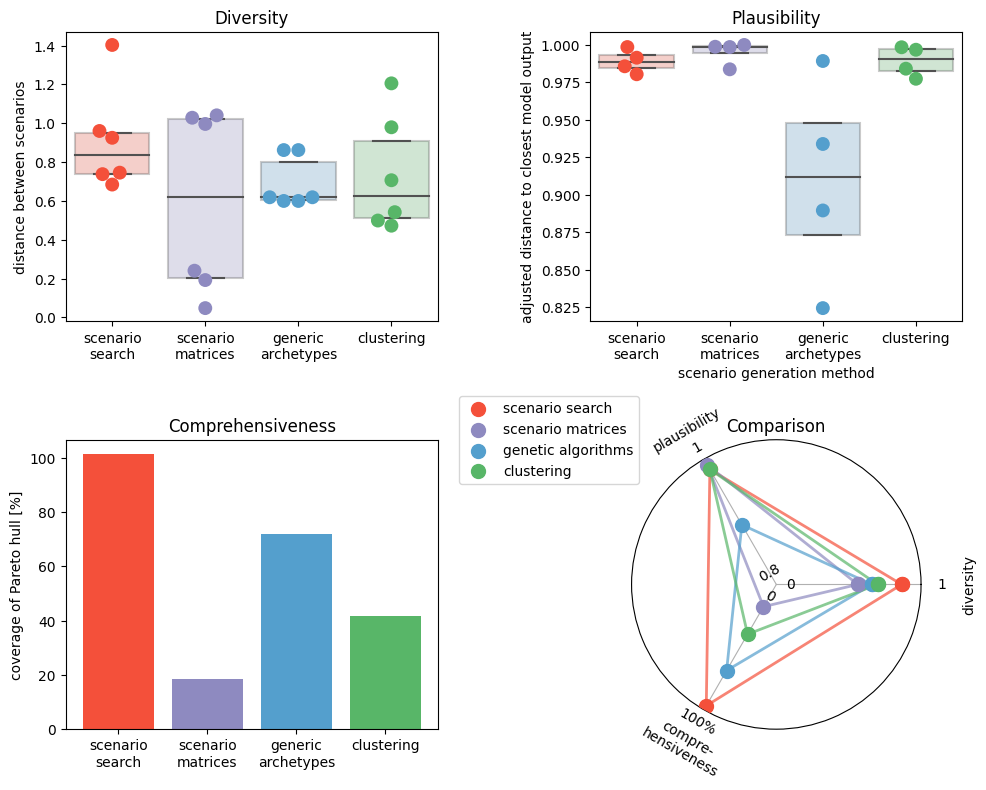

In [81]:
plt.rcParams["figure.figsize"] = (10,8)

plt.subplot(2, 2, 1, title="Diversity")
s = sns.swarmplot(data=df_distances,size=10, palette = cmap.colors)
s = sns.boxplot(data=df_distances, boxprops=dict(alpha=.3),showfliers=False,whis=0, palette = cmap.colors)
s.set_xticklabels(['scenario\nsearch','scenario\nmatrices','generic\narchetypes','clustering'])
#plt.xlabel('scenario generation method')
plt.ylabel('distance between scenarios')





plt.subplot(2, 2, 2, title="Plausibility")
plt.rcParams["figure.figsize"] = (6,3)
s = sns.swarmplot(data=df_plausibility_recip,size=10, palette = cmap.colors)#, marker="s")
s = sns.boxplot(data=df_plausibility_recip, boxprops=dict(alpha=.3),showfliers=False,whis=0, palette = cmap.colors)
s.set_xticklabels(['scenario\nsearch','scenario\nmatrices','generic\narchetypes','clustering'])
plt.xlabel('scenario generation method')
plt.ylabel('adjusted distance to closest model output')
s.plot()





plt.subplot(2, 2, 3, title="Comprehensiveness")
plt.bar(x=[1,2,3,4], height = list(comprehensiveness_dict.values()), color = cmap.colors, tick_label = ['scenario\nsearch','scenario\nmatrices','generic\narchetypes','clustering'])
#plt.xlabel('scenario generation method')
plt.ylabel('coverage of Pareto hull [%]')






ax = plt.subplot(2, 2, 4, projection='polar')
ax.title.set_text("Comparison")

ax.set_rticks([])  # Less radial ticks
#ax.set_rgrids(radii=[1.1/(3/2),1.1/3], labels = "")
ax.set_thetagrids(angles=[0,120,240],labels=[])

polar_data = {
"scenario search": append_first(radar_df.drop("method",axis=1).iloc[0].tolist()),
"scenario matrices": append_first(radar_df.drop("method",axis=1).iloc[1].tolist()),
"genetic algorithms": append_first(radar_df.drop("method",axis=1).iloc[2].tolist()),
"clustering": append_first(radar_df.drop("method",axis=1).iloc[3].tolist())
}

for key, color in zip(polar_data,[0,1,2,3]):
    ax.scatter([0,np.pi*2/3,np.pi*4/3,0],polar_data[key], color = cmap.colors[color], label = key, s = 100, zorder=10)
    ax.plot([0,np.pi*2/3,np.pi*4/3,0],polar_data[key], color = cmap.colors[color], linewidth=2, alpha=0.7)

ax.text(0,0.1, '0',ha='center', va="center")
ax.text(0,1.2, '1',ha='center', va="center")
ax.text(0,1.4, 'diversity',ha='center', va="center", rotation = 90)

ax.text(np.pi*2/3,0.1, '0.8',ha='center', va="center", rotation = 30)
ax.text(np.pi*2/3,1.15, '1',ha='center', va="center", rotation = 30)
ax.text(np.pi*2/3,1.3, 'plausibility',ha='center', va="center", rotation = 30)

ax.text(np.pi*4/3,0.1, '0',ha='center', va="center", rotation = 330)
ax.text(np.pi*4/3,1.15, '100%',ha='center', va="center", rotation = 330)
ax.text(np.pi*4/3,1.35, 'compre-\nhensiveness',ha='center', va="center", rotation = 330)

ax.set_rmin(0)
ax.set_rmax(1.05)

plt.legend(loc='center right', bbox_to_anchor=(0.05,1))

plt.tight_layout()
plt.savefig("./figures/criteria", dpi = 600 )
plt.show()